In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Transmisión de información y Compresión 



Digamos que queremos transmitir un video en 4K a través de internet

¿Cúanto pesa una imagen en resolución 4K a color y con 255 niveles de intensidad?

In [2]:
3840*2160*3*8

199065600

Aproximadamente 200 [Mb]

:::{note}

Un video es una secuencia de imágenes corriendo a una cierta tasa medida en cuadros por segundo (fps). Un estándar típico es 24 fps, lo cual es suficiente para dar la ilusión de movimiento fluido. 

:::

¿Cuánto ancho de banda se necesita para ver un video a 24 fps en tiempo real (sin audio)?

In [3]:
200*24

4800

Es decir casi 4.8 [Gb/s]$.

Si comparamos este valor con la velocidad de descarga de los planes de internet, resulta ser claramente infactible

:::{warning}

¿Cómo pueden entonces funcionar los servicios de streaming de video por internet?

:::

En general estos servicios comprimen la información durante el proceso de codificación

:::{important}

Comprimir es codificar la información usando "menos bits" que la representación original

:::

La compresión puede ser de tipo

- *Lossless* (sin pérdidas): Los datos originales pueden reconstruirse perfectamente
- *Lossy* (con pérdidas): Se reconstruye una versión aproximada de los datos originales

Los compresores de audio, imágenes y video son en general de tipo *lossy*

En esta sesión estudiaremos el bloque transmisor del estándar JPEG para imágenes y sus derivados para video

## Modelo transmisor de Shannon

Recordemos el modelo de Shannon

<img src="../signals/images/shannon-diagram.svg" width="500">

El **transmisor** puede subdividirse en cuatro etapas

<img src="images/transmitter.svg" width="600">

donde

: Transformación
Cambia la representación de los datos de forma tal de disminuir su redudancia y correlación

: Cuantización
Reduce la cantidad de bits que se usan para representar la señal. **Este paso provoca pérdidas en la señal**, por lo que sólo se ocupa cuando no es necesario recuperar la señal de forma perfecta luego de transmitir

: Codificación de fuente
Reescribe la señal usando un **código de largo variable**

: Codificación de canal
Robustece el código para que pueda transmitirse por un canal posiblemente ruidoso con menos errores


En lecciones anteriores hemos visto la FFT, la cual es ampliamente utilizada para transformar señales de audio e imágenes. También se estudiaron los pasos de codificación junto a la teoría de la información. 

A continuación se explica en detalle en que consiste la **cuantización**

## Cuantización 

:::{important}

La cuantización es una operación de redondeo o truncamiento

:::

El ejemplo más clásico se conoce como cuantización escalar. Esta operación recibe una señal $x$ y retorna un nuevo valor definido como

$$
\begin{equation}
    Q(x)=
    \begin{cases}
      r_0, & x \in [d_0, d_1) \\
      r_1, & x \in [d_1, d_2) \\
      \vdots & \vdots \\
      r_i, & x \in [d_i, d_{i+1}) \\
      \vdots & \vdots \\
      r_{L-1}& x \in [d_{L-1}, d_{L}) \\
    \end{cases}
\end{equation}
$$

donde el diseñador del cuantizar debe decidir la cantidad y valor de $r_i$ y también los límites o fronteras $d_i$

Un caso particular es la **cuantización uniforme** donde la diferencia entre los niveles $q$ es constante

Si $d_0 = -V$ y $d_L = V$, una cuantización uniforme de $L$ niveles sería

$$
q = \frac{2V}{L}
$$

$$
d_{i} = d_{i-1} + q  = d_0 + i q = -V + i \frac{2V}{L}
$$

y el valor de representación es el punto medio de cada nivel

$$
r_i = \frac{1}{2} (d_i + d_{i+1}) = -d_0 + \frac{2i+1}{2} \Delta = -V + (2i+1) \frac{V}{L}
$$ 

También podríamos definir $q$ y usar la fórmula

$$
x_q = -V + \frac{q}{2} + q\cdot \text{floor}\left(\frac{x+V}{q} \right)
$$


La calidad de la señal cuantizada se mide usando el error de cuantización o diferencia cuadrática entre el valor real y su versión cuantizada

$$
d_c = \|Q(x) -x\|^2
$$

**Ejemplo**

Cuantización uniforme de una señal sinusoidal con distintos valores de $q $

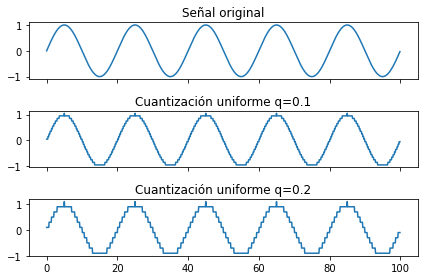

In [4]:
def quantize_uniform(x, x_min, q):
    return x_min + q/2 + np.floor((x-x_min)/q)*q

t = np.arange(100, step=0.1)
s1 = np.sin(2.0*np.pi*t*0.05)
s2 = quantize_uniform(s1, s1.min(), q=0.1)
s3 = quantize_uniform(s1, s1.min(), q=0.2)

fig, ax = plt.subplots(3, figsize=(6, 4), tight_layout=True, sharex=True)
ax[0].plot(t, s1)
ax[0].set_title('Señal original')
ax[1].plot(t, s2)
ax[1].set_title('Cuantización uniforme q=0.1')
ax[2].plot(t, s3);
ax[2].set_title('Cuantización uniforme q=0.2');

##  Joint Photographic Experts Group (JPEG)

A modo de ejemplo estudiaremos en detalle el (ampliamente utilizado) estándar [ISO](https://es.wikipedia.org/wiki/Organizaci%C3%B3n_Internacional_de_Normalizaci%C3%B3n)/ITU para comprimir imágenes digitales conocido como JPEG. 

En esencia JPEG corresponde a un método de compresión con pérdidas (*lossy*) que considera los siguientes pasos 

1. Transformación:
    1. Conversión a estándar YCbCr 
    1. **Submuestreo de canales de color**
    1. Transformada discreta coseno (DCT) por bloques de 8x8 píxeles
1. Cuantización:
    1. **Cuantización escalar con matriz Q por bloques de 8x8 pixeles**
1. Codificación de fuente:
    1. Reordenamiento zig-zag 
    1. Codificación Run-length
    1. Codificación de Huffman
    
(los pasos en **bold** tienen pérdidas)

Un archivo en formato JPEG contiene los bloques de 8x8 codificados (cuerpo) y el diccionario de codificación (header)

El siguiente diagrama muestra el bloque transmisor JPEG:

<img src="images/jpg-transmisor.png" width="500"> 

Para descomprimir una imagen JPEG se realizan los pasos anteriores en reversa, por ende se necesita tener el diccionario de codificación. El siguiente diagrama muestra el bloque receptor JPEG:

<img src="images/jpg-receptor.png" width="500"> 

A continuación estudiaremos cada uno de estos pasos

### Transformación: Preprocesamiento

Primero se convierte la imagen a estándar YCbCr. Luego (opcionalmente) se reduce la resolución de los canales chroma (Cb y Cr) con respecto al canal de luminancia (Y)

Algunas estándares de submuestreo de color son

<img src="images/422.jpg" width="600">

Donde por ejemplo 4:2:2 significa que los canales chroma tienen la mitad de la resolución de la luminancia

:::{note}

Este submuestreo aprovecha que el sistema visual humano es más sencible a la iluminación que al color

:::


**Ejemplo**

Podemos usar opencv y numpy para hacer submuestreo 4:2:2 como se muestra a continuación

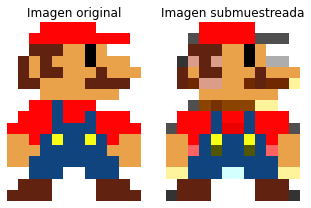

In [5]:
def chroma_subsampling_422(image_rgb):
    Y, Cr, Cb = cv2.split(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb))
    Cr = np.repeat(Cr[::2, :], 2, axis=0)
    Cb = np.repeat(Cb[::2, :], 2, axis=0)
    image_subsampled = cv2.merge([Y, Cr, Cb])
    return cv2.cvtColor(image_subsampled.astype('uint8'), cv2.COLOR_YCrCb2RGB) 

mario = cv2.imread("data/mario.png") 
mario = cv2.cvtColor(mario, cv2.COLOR_BGR2RGB)
mario_ss = chroma_subsampling_422(mario)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), tight_layout=True)
ax[0].imshow(mario)
ax[0].axis('off')
ax[0].set_title('Imagen original')
ax[1].imshow(mario_ss)
ax[1].axis('off')
ax[1].set_title('Imagen submuestreada');

**Ejemplo 2**

En el ejemplo anterior hay diferencias notorias causadas por el submuestreo, pero en imágenes naturales estas diferencias son casi imperceptibles

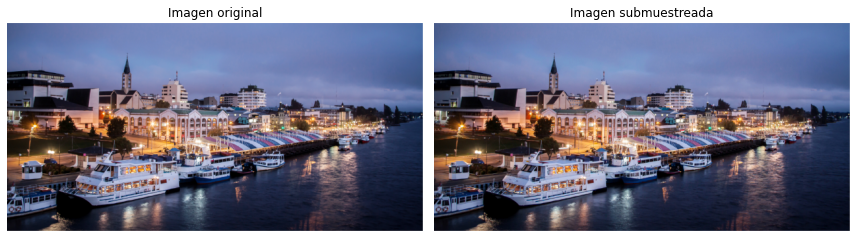

In [6]:
valdivia = cv2.imread("data/valdivia-hd.png") 
valdivia = cv2.cvtColor(valdivia, cv2.COLOR_BGR2RGB)
valdivia_ss = chroma_subsampling_422(valdivia)

fig, ax = plt.subplots(1, 2, figsize=(12, 7), tight_layout=True)
ax[0].imshow(valdivia)
ax[0].axis('off')
ax[0].set_title('Imagen original')
ax[1].imshow(valdivia_ss)
ax[1].axis('off')
ax[1].set_title('Imagen submuestreada');

### Transformación: Transformada Coseno

Luego de submuestrear el algoritmo JPEG se aplica secuencialmente en bloques disjuntos de 8x8 píxeles

Cada bloque se lleva al dominio de la frecuencia usando la transformada discreta coseno

Sea una señal discreta y bidimensional $g[n_1, n_2]$ con índices $n_1 \in [0, N_1-1]$ y $n_2 \in [0, N_2-1]$ su DCT es 

$$
G_C[k_1, k_2] = \sum_{n_1=0}^{N_1-1} \sum_{n_2=0}^{N_2-1} 4 g[n_1, n_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right) 
$$
y su inversa

$$
g[n_1, n_2] = \frac{1}{N_1 N_2}\sum_{k_1=0}^{N_1-1} \sum_{k_2=0}^{N_2-1} w[k_1]w[k_2]G[k_1, k_2] \cos \left ( \frac{\pi k_1}{2N_1}(2n_1+1)  \right) \cos \left ( \frac{\pi k_2}{2N_2}(2n_2+1)  \right), 
$$

donde 

$$
w[k] =\begin{cases}
1/2 & \text{ssi} ~~ k=0\\
1 & \text{ssi} ~~ k \neq 0
\end{cases} 
$$

La DCT bidimensional:

- se puede descomponer en 2 aplicaciones de la DCT 1D
- es lineal, y cumple el principio de conservación de energía. Podemos llevar una imagen al espacio de frecuencias sin pérdida de información
- es equivalente a la DFT de una señal "simetricamente extendida"

$$
y[k] =\begin{cases}
x[k] & \text{ssi} ~~ k<N\\
x[2N-1-k] & \text{ssi} ~~ N \leq k < 2N - 1 
\end{cases} 
$$

Es decir que podemos usar el algoritmo FFT para calcular eficientemente la DCT


:::{warning}

La convolución en espacio original no es multiplicación en el espacio DCT

:::

**Ejemplo:** 

Así se ve una imagen simetricamente extendida 

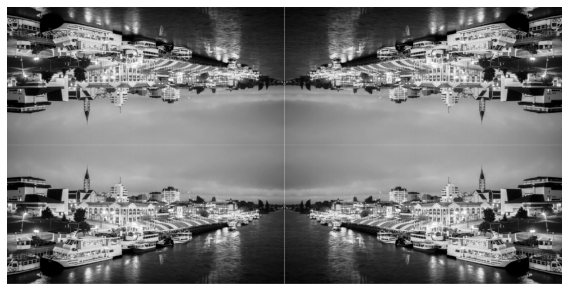

In [7]:
valdivia_bw = cv2.cvtColor(valdivia, cv2.COLOR_RGB2YCR_CB)[:, :, 0]
valdivia_bw_sym = np.hstack((valdivia_bw, np.fliplr(valdivia_bw)))
valdivia_bw_sym = np.vstack((np.flipud(valdivia_bw_sym), valdivia_bw_sym))

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.axis('off')
ax.imshow(valdivia_bw_sym, cmap=plt.cm.Greys_r);

:::{note}

Debido a esta "simetría incorporada" la DCT no tiene artefactos de borde como la FFT

:::

**Ejemplo:** 

La transformada coseno y su inversa están implementada en opencv como [cv2.dct](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga85aad4d668c01fbd64825f589e3696d4). La imagen debe convertirse a flotante antes de aplicar la DCT. 

A continuación se aplica la DCT a los bloques de 8x8 de la imagen anterior

In [8]:
dct_matrix = np.zeros_like(valdivia_bw).astype('float32')

for i in range(0, valdivia_bw.shape[0], 8):
    for j in range(0, valdivia_bw.shape[1], 8):
        dct_matrix[i:(i+8),j:(j+8)] = cv2.dct(valdivia_bw[i:(i+8),j:(j+8)].astype('float32'))

¿Cómo se ven estos bloques? 

Por ejemplo el bloque número 15 y su DCT:

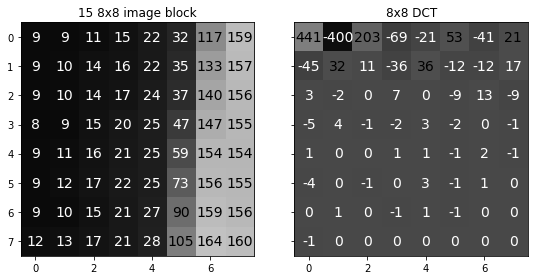

In [9]:
def plot_values(ax, tile, fontsize=14):
    mid = (tile.max() + tile.min())/2.
    for i in range(8):
        for j in range(8):
            label = tile[i, j]
            color = 'black' if label > mid else 'white'
            ax.text(j, i, int(label), fontsize=fontsize, 
                    color=color, ha='center', va='center')
            
block_idx = 15
bloque_pixels = valdivia_bw[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
bloque_dct = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ax[0].imshow(bloque_pixels, cmap=plt.cm.Greys_r, 
             vmin=valdivia_bw.min(), vmax=valdivia_bw.max())
ax[0].set_title("%d 8x8 image block" %(block_idx)); 
plot_values(ax[0], bloque_pixels)
# DCT 8x8
ax[1].imshow(bloque_dct, cmap=plt.cm.Greys_r, 
             vmin=dct_matrix.min(), vmax=dct_matrix.max())
ax[1].set_title("8x8 DCT")
plot_values(ax[1], bloque_dct);

Una imagen tiene mucha correlación entre sus píxeles vecinos

Al llevarla al espacio de frecuencia esta información se concentra en el cero (centro) del espectro

- La frecuencia cero del bloque DCT es la esquina superior izquierda
- La frecuencia aumenta de izquierda a derecha y de arriba hacia abajo
 
:::{note}

Muchos de los coeficientes de alta frecuencia de la DCT tienen valores bajos 

:::

:::{important}

La DCT ha disminuido la redundancia en la información

:::

### Cuantización en JPEG

En este paso se busca cuantizar cada matriz DCT de 8x8 y reducir la "cantidad de valores posibles"

Recordemos que JPEG cuantiza en el espacio de frecuencia

- Cada bloque de 8x8 de componentes DCT se cuantiza por separado
- El nivel de cada uno de los componentes se redondea según una matriz de cuantización Q
- Q fue diseñada tal que componentes de alta frecuencia se cuantizan en menos niveles
- Existen muchas implementaciones de la matriz Q según fabricante y equipo: https://www.impulseadventure.com/photo/jpeg-quantization.html

In [10]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

El bloque cuantizado se obtiene como $\text{ROUND}\left(\frac{G_C}{Q}\right)$

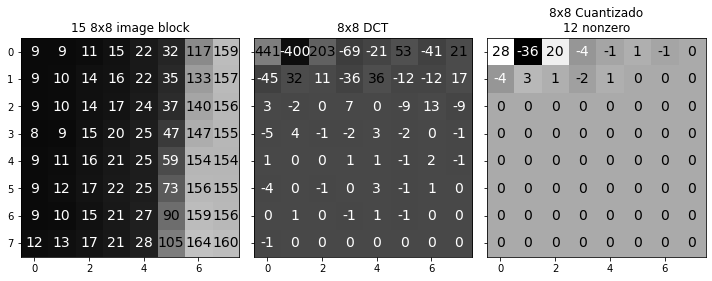

In [11]:
block_idx = 15
bloque_pixels = valdivia_bw[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
bloque_dct = dct_matrix[8*block_idx:8*block_idx+8, 8*block_idx:8*block_idx+8]
bloque_cuantizado = np.round(bloque_dct/Q)

fig, ax = plt.subplots(1, 3, figsize=(10, 4), tight_layout=True, sharey=True)
ax[0].imshow(bloque_pixels, cmap=plt.cm.Greys_r, vmin=valdivia_bw.min(), vmax=valdivia_bw.max())
ax[0].set_title("%d 8x8 image block" %(block_idx)); 
plot_values(ax[0], bloque_pixels)
# DCT 8x8
ax[1].imshow(bloque_dct, cmap=plt.cm.Greys_r, vmin=dct_matrix.min(), vmax=dct_matrix.max())
ax[1].set_title("8x8 DCT")
plot_values(ax[1], bloque_dct)
ax[2].imshow(bloque_cuantizado, cmap=plt.cm.Greys_r)
plot_values(ax[2], bloque_cuantizado)
ax[2].set_title("8x8 Cuantizado\n%d nonzero" %(np.count_nonzero(bloque_cuantizado))); 

**Ejemplo**

El nivel de cuantización de JPEG se controla como un valor denominado tipicamente como calidad que va entre 0 y 100

A mayor calidad se aplica menor cuantización, resultando en un archivo más pesado

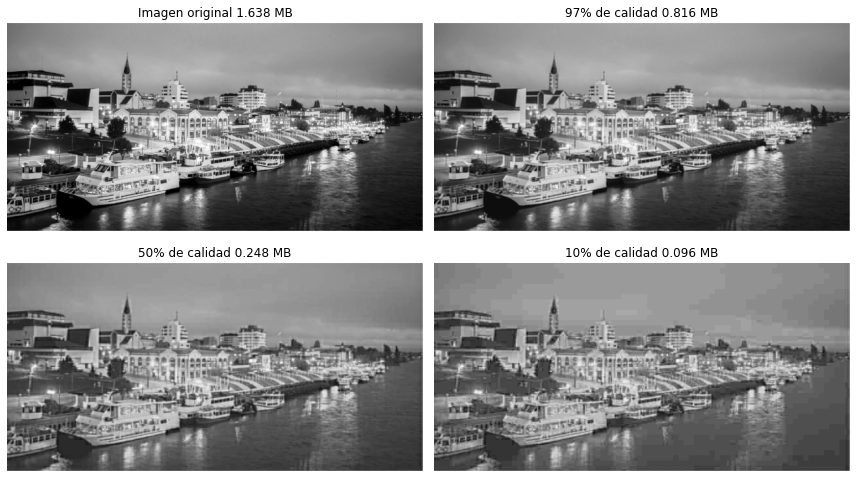

In [12]:
def cuantizar_y_reconstruir(dct_matrix, percent):    
    im_recon = np.zeros_like(dct_matrix)
    nnz = np.zeros_like(dct_matrix)
    if (percent < 50):
        S = 5000/percent
    else:
        S = 200 - 2*percent 
    Q_dyn = np.floor((S*Q + 50) / 100);
    Q_dyn[Q_dyn == 0] = 1
    for i in range(0, dct_matrix.shape[0], 8):
        for j in range(0, dct_matrix.shape[1], 8):
            quant = np.round(dct_matrix[i:(i+8),j:(j+8)]/Q_dyn) 
            im_recon[i:(i+8),j:(j+8)] = cv2.dct(quant, flags=cv2.DCT_INVERSE)
            nnz[i, j] = np.count_nonzero(quant)    
    im_min, im_max = np.amin(im_recon), np.amax(im_recon)
    im_recon = (im_recon - im_min)/(im_max-im_min) # Min-Max Rescaling
    return (255*im_recon).astype('uint8'), np.sum(nnz)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 7), tight_layout=True)
ax[0, 0].imshow(valdivia_bw, cmap=plt.cm.Greys_r); 
ax[0, 0].set_title(f"Imagen original {np.prod(valdivia_bw.shape)*8/1e+6:0.3f} MB")
ax[0, 0].axis('off')

for k, (quality,ax_) in enumerate(zip([97, 50, 10], ax.ravel()[1:])):
    imc, nnz = cuantizar_y_reconstruir(dct_matrix, quality)
    ax_.imshow(imc, cmap=plt.cm.Greys_r); 
    ax_.set_title(f"{quality}% de calidad {nnz*8/1e+6:0.3f} MB")
    ax_.axis('off');

### Codificación de fuente

En JPEG se ocupa códificación de Huffmann, pero existen dos pasos previos a aplicar la codificación

El primer es el reordenamiento zig-zag de los bloques de 8x8. Luego de cuantizar el bloque de 8x8 este se reordena como una tira de largo 64 aplicando un reordenamiento de tipo zig-zag

<img src="images/Zig-Zag-reordering-matrix.png" width="500">

El reordenamiento en zig zag crea un vector donde los componentes están ordenados por frecuencia y los ceros (de las frecuencias altas) quedan más cerca

:::{note}

Puedes revisar el algoritmo para generar el arreglo zig-zag en distintos lenguajes aquí: https://rosettacode.org/wiki/Zig-zag_matrix

:::

Luego de reordenar se aplica Run Length Enconding (RLE), una codificación sencilla y sin pérdida, que es muy eficiente cuando tenemos valores que se repiten

Los datos codificados son tuplas (nrep, valor) concatenadas, donde nrep es la cantidad de veces que se repitió valor, como muestra la siguiente figura

<img src="images/rle.jpg" width="500">

:::{note}

El reordenamiento zig-zag hace más eficiente el RLE pues tiende a dejar todos los ceros juntos

:::

Luego de RLE se aplica la codificación de Huffmann que vimos en una lección anterior

## Algoritmos de compresión para video

Consideremos ahora el caso en que tenemos un stream de video (sin audio) y queremos transmitirlo comprimido

Un algoritmo clásico es Motion-JPEG el cual se basa en el algoritmo JPEG que ya hemos visto. Tiene dos variantes

<img src="images/MJPEG.png"  width="450">

- La primera denominada **intraframe** consiste en aplicar el algoritmo JPEG a cada cuadro como si fueran imágenes independientes. Es un algoritmo simple pero ingenuo ya que no está tomando en cuenta que existe mucha correlación entre cuadros
- La segunda denominada **interframe** consiste en aplicar el algoritmo JPEG a las diferencias entre cuadros. Si los movimientos son lentos las diferencias entre cuadros serán pequeñas y la codificación entrópica podrá reducir mucho más el tamaño. En general se codifica un cuadro completo denominado keyframe y luego una cierta cantidad de diferencias entre el keyframe y los cuadros siguientes. 

Esta idea es la que está detrás de algoritmos más modernos como MPEG

<img src="images/MPEG.png" width="500">

MPEG es un estándar de codificación para video de tipo inter-frame que explota la redundancia entre los bloques de 8x8 de un cuadro y su sucesor 

Existen tres tipos de cuadro/frame en MPEG-1

- I: Se comprime el frame completo con JPEG. Se envía una frame I cada N frames
- P: Se predicen las diferencias con respecto al frame I o P anterior. 
- B: Se calculan diferencias en base al frame I o P más cercano anterior y posterior
